In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd
import time
import re
import os

class HousingCrawler:
    def __init__(self):
        self.driver = webdriver.Chrome()
        self.wait = WebDriverWait(self.driver, 15)
        
        # 定义所有要爬取的区域URL
        self.regions = {
            "万柳": {
                "second_hand": "https://esf.fang.com/house-a015277-b02313/",
                "rental": "https://zu.fang.com/house-a015277-b02313/"
            },
            "苏州桥": {
                "second_hand": "https://esf.fang.com/house-a015277-b02655/",
                "rental": "https://zu.fang.com/house-a015277-b02655/"
            },
            "北太平庄": {
                "second_hand": "https://esf.fang.com/house-a015277-b05/",
                "rental": "https://zu.fang.com/house-a015277-b05/"
            },
            "世纪城": {
                "second_hand": "https://esf.fang.com/house-a015277-b03115/",
                "rental": "https://zu.fang.com/house-a015277-b03115/"
            }
        }
    
    def crawl_second_hand_houses(self, region_name, url):
        """爬取指定区域的二手房数据"""
        print(f"开始爬取{region_name}二手房数据...")
        self.driver.get(url)
        time.sleep(2)
        
        all_data = []
        max_pages = 20  # 限制爬取页数
        
        for page in range(max_pages):
            print(f"正在爬取{region_name}二手房第{page+1}页...")
            
            try:
                # 等待房源列表加载
                self.wait.until(
                    EC.presence_of_element_located((By.XPATH, "//dl[contains(@class, 'clearfix') and @dataflag='bg']"))
                )
                
                # 获取所有房源
                houses = self.driver.find_elements(By.XPATH, "//dl[contains(@class, 'clearfix') and @dataflag='bg']")
                print(f"找到 {len(houses)} 个房源")
                
                for i, house in enumerate(houses):
                    try:
                        # 提取面积信息
                        try:
                            area_element = house.find_element(By.CLASS_NAME, "tel_shop")
                            area_text = area_element.text
                            area_match = re.search(r'(\d+\.?\d*)\s*㎡', area_text)
                            if area_match:
                                area = float(area_match.group(1))
                            else:
                                continue
                        except Exception as e:
                            continue
                        
                        # 提取价格信息
                        try:
                            price_element = house.find_element(By.CLASS_NAME, "price_right")
                            price_span = price_element.find_element(By.CLASS_NAME, "red")
                            price_b = price_span.find_element(By.TAG_NAME, "b")
                            price_text = price_b.text
                            price_match = re.search(r'(\d+\.?\d*)', price_text)
                            if price_match:
                                price = float(price_match.group(1))
                            else:
                                continue
                        except Exception as e:
                            continue
                            
                        house_data = {
                            '区域': region_name,
                            '面积(㎡)': area,
                            '价格(万)': price
                        }
                        all_data.append(house_data)
                        
                    except Exception as e:
                        continue
                
                # 翻页功能
                try:
                    next_page = self.driver.find_element(By.XPATH, "//a[contains(text(), '下一页')]")
                    next_page.click()
                    time.sleep(1)
                except NoSuchElementException:
                    print(f"{region_name}二手房没有找到下一页按钮，已到达最后一页")
                    break
                    
            except Exception as e:
                print(f"爬取{region_name}二手房第{page+1}页时出错: {e}")
                break
        
        df = pd.DataFrame(all_data)
        if not df.empty:
            df['单价(元/㎡)'] = (df['价格(万)'] * 10000 / df['面积(㎡)']).round(2)
        return df
    
    def crawl_rental_houses(self, region_name, url):
        """爬取指定区域的租房数据"""
        print(f"开始爬取{region_name}租房数据...")
        self.driver.get(url)
        time.sleep(3)
        
        all_data = []
        max_pages = 20  # 限制爬取页数
        
        for page in range(max_pages):
            print(f"正在爬取{region_name}租房第{page+1}页...")
            
            try:
                # 等待房源列表加载
                self.wait.until(
                    EC.presence_of_element_located((By.CLASS_NAME, "houseList"))
                )
                
                # 获取所有房源
                houses = self.driver.find_elements(By.CLASS_NAME, "list")
                print(f"找到 {len(houses)} 个租房房源")
                
                for i, house in enumerate(houses):
                    try:
                        # 提取面积信息
                        try:
                            area_element = house.find_element(By.CLASS_NAME, "font15")
                            area_text = area_element.text
                            area_match = re.search(r'(\d+\.?\d*)\s*㎡', area_text)
                            if area_match:
                                area = float(area_match.group(1))
                            else:
                                continue
                        except Exception as e:
                            continue
                        
                        # 提取价格信息
                        try:
                            more_info = house.find_element(By.CLASS_NAME, "moreInfo")
                            price_element = more_info.find_element(By.CLASS_NAME, "price")
                            price_text = price_element.text
                            price_match = re.search(r'(\d+\.?\d*)', price_text)
                            if price_match:
                                price = float(price_match.group(1))
                            else:
                                continue
                        except Exception as e:
                            try:
                                price_elements = house.find_elements(By.CLASS_NAME, "price")
                                if price_elements:
                                    price_text = price_elements[0].text
                                    price_match = re.search(r'(\d+\.?\d*)', price_text)
                                    if price_match:
                                        price = float(price_match.group(1))
                                    else:
                                        continue
                                else:
                                    continue
                            except:
                                continue
                            
                        house_data = {
                            '区域': region_name,
                            '面积(㎡)': area,
                            '租金(元/月)': price
                        }
                        all_data.append(house_data)
                        
                    except Exception as e:
                        continue
                
                # 翻页功能
                try:
                    next_page = self.driver.find_element(By.XPATH, "//a[contains(text(), '下一页')]")
                    next_page.click()
                    time.sleep(1)
                except NoSuchElementException:
                    print(f"{region_name}租房没有找到下一页按钮，已到达最后一页")
                    break
                    
            except Exception as e:
                print(f"爬取{region_name}租房第{page+1}页时出错: {e}")
                break
        
        df = pd.DataFrame(all_data)
        if not df.empty:
            df['租金单价(元/㎡/月)'] = (df['租金(元/月)'] / df['面积(㎡)']).round(2)
        return df
    
    def crawl_all_regions(self):
        """爬取所有区域的数据"""
        all_second_hand = []
        all_rental = []
        
        for region_name, urls in self.regions.items():
            # 爬取二手房数据
            second_hand_df = self.crawl_second_hand_houses(region_name, urls["second_hand"])
            if not second_hand_df.empty:
                all_second_hand.append(second_hand_df)
            
            # 爬取租房数据
            rental_df = self.crawl_rental_houses(region_name, urls["rental"])
            if not rental_df.empty:
                all_rental.append(rental_df)
            
            time.sleep(2)  # 区域间延迟
        
        # 合并所有数据
        second_hand_combined = pd.concat(all_second_hand, ignore_index=True) if all_second_hand else pd.DataFrame()
        rental_combined = pd.concat(all_rental, ignore_index=True) if all_rental else pd.DataFrame()
        
        return second_hand_combined, rental_combined
    
    def save_to_excel(self, df, filename):
        """保存数据到Excel"""
        current_dir = os.getcwd()
        file_path = os.path.join(current_dir, filename)
        df.to_excel(file_path, index=False)
        print(f"数据已保存到: {file_path}")
    
    def close(self):
        """关闭浏览器"""
        self.driver.quit()
        print("浏览器已关闭")

# 主程序
def main():
    crawler = HousingCrawler()
    
    try:
        # 爬取所有区域数据
        print("开始爬取所有区域数据...")
        second_hand_df, rental_df = crawler.crawl_all_regions()
        
        if not second_hand_df.empty:
            print(f"\n二手房数据总记录数: {len(second_hand_df)}")
            crawler.save_to_excel(second_hand_df, "所有区域二手房数据.xlsx")
            print("\n二手房数据样本:")
            print(second_hand_df.head())
        else:
            print("未获取到二手房数据")
        
        if not rental_df.empty:
            print(f"\n租房数据总记录数: {len(rental_df)}")
            crawler.save_to_excel(rental_df, "所有区域租房数据.xlsx")
            print("\n租房数据样本:")
            print(rental_df.head())
        else:
            print("未获取到租房数据")
            
    except Exception as e:
        print(f"程序执行出错: {e}")
        import traceback
        traceback.print_exc()
    finally:
        crawler.close()

if __name__ == "__main__":
    main()

There was an error managing chromedriver (error decoding response body); using driver found in the cache


开始爬取所有区域数据...
开始爬取万柳二手房数据...
正在爬取万柳二手房第1页...
找到 60 个房源
正在爬取万柳二手房第2页...
找到 60 个房源
正在爬取万柳二手房第3页...
找到 60 个房源
正在爬取万柳二手房第4页...
找到 60 个房源
正在爬取万柳二手房第5页...
找到 60 个房源
正在爬取万柳二手房第6页...
找到 60 个房源
正在爬取万柳二手房第7页...
找到 60 个房源
正在爬取万柳二手房第8页...
找到 60 个房源
正在爬取万柳二手房第9页...
找到 60 个房源
正在爬取万柳二手房第10页...
找到 60 个房源
正在爬取万柳二手房第11页...
找到 60 个房源
正在爬取万柳二手房第12页...
找到 60 个房源
正在爬取万柳二手房第13页...
找到 60 个房源
正在爬取万柳二手房第14页...
找到 60 个房源
正在爬取万柳二手房第15页...
找到 60 个房源
正在爬取万柳二手房第16页...
找到 60 个房源
正在爬取万柳二手房第17页...
找到 60 个房源
正在爬取万柳二手房第18页...
找到 60 个房源
正在爬取万柳二手房第19页...
找到 60 个房源
正在爬取万柳二手房第20页...
找到 60 个房源
开始爬取万柳租房数据...
正在爬取万柳租房第1页...
找到 60 个租房房源
正在爬取万柳租房第2页...
找到 60 个租房房源
正在爬取万柳租房第3页...
找到 60 个租房房源
正在爬取万柳租房第4页...
找到 60 个租房房源
正在爬取万柳租房第5页...
找到 60 个租房房源
正在爬取万柳租房第6页...
找到 60 个租房房源
正在爬取万柳租房第7页...
找到 60 个租房房源
正在爬取万柳租房第8页...
找到 60 个租房房源
正在爬取万柳租房第9页...
找到 60 个租房房源
正在爬取万柳租房第10页...
找到 60 个租房房源
正在爬取万柳租房第11页...
找到 60 个租房房源
正在爬取万柳租房第12页...
找到 60 个租房房源
正在爬取万柳租房第13页...
找到 60 个租房房源
正在爬取万柳租房第14页...
找到 60 个租房房源
正在爬取万柳租房第15页...
找到 60 个租房房源
正在爬取万柳租房第16页...

开始数据清洗...
二手房原始数据量: 2905
去重后二手房数据量: 819
租房原始数据量: 2932
去重后租房数据量: 590
在 单价(元/㎡) 中移除了 44 个异常值
在 面积(㎡) 中移除了 31 个异常值
在 租金单价(元/㎡/月) 中移除了 35 个异常值
在 面积(㎡) 中移除了 35 个异常值
去除异常值后二手房数据量: 744
去除异常值后租房数据量: 520

数据描述和异常值分析

=== 二手房数据描述 ===

--- 万柳 ---
记录数: 208
单价统计:
  平均值: 132174.61 元/㎡
  中位数: 133016.61 元/㎡
  标准差: 25745.14 元/㎡
  最小值: 35245.90 元/㎡
  最大值: 198550.39 元/㎡
  单价异常值数量: 4

--- 苏州桥 ---
记录数: 156
单价统计:
  平均值: 81077.24 元/㎡
  中位数: 80952.38 元/㎡
  标准差: 14139.76 元/㎡
  最小值: 44927.32 元/㎡
  最大值: 152985.07 元/㎡
  单价异常值数量: 6

--- 北太平庄 ---
记录数: 113
单价统计:
  平均值: 87427.45 元/㎡
  中位数: 90604.03 元/㎡
  标准差: 22946.45 元/㎡
  最小值: 32025.91 元/㎡
  最大值: 129124.82 元/㎡
  单价异常值数量: 11

--- 世纪城 ---
记录数: 267
单价统计:
  平均值: 112477.32 元/㎡
  中位数: 109016.39 元/㎡
  标准差: 18576.49 元/㎡
  最小值: 64885.50 元/㎡
  最大值: 183346.59 元/㎡
  单价异常值数量: 2

=== 租房数据描述 ===

--- 万柳 ---
记录数: 67
租金单价统计:
  平均值: 151.01 元/㎡/月
  中位数: 146.34 元/㎡/月
  标准差: 29.64 元/㎡/月
  最小值: 101.33 元/㎡/月
  最大值: 226.13 元/㎡/月
  租金单价异常值数量: 0

--- 苏州桥 ---
记录数: 191
租金单价统计:
  平均值: 129.90 元

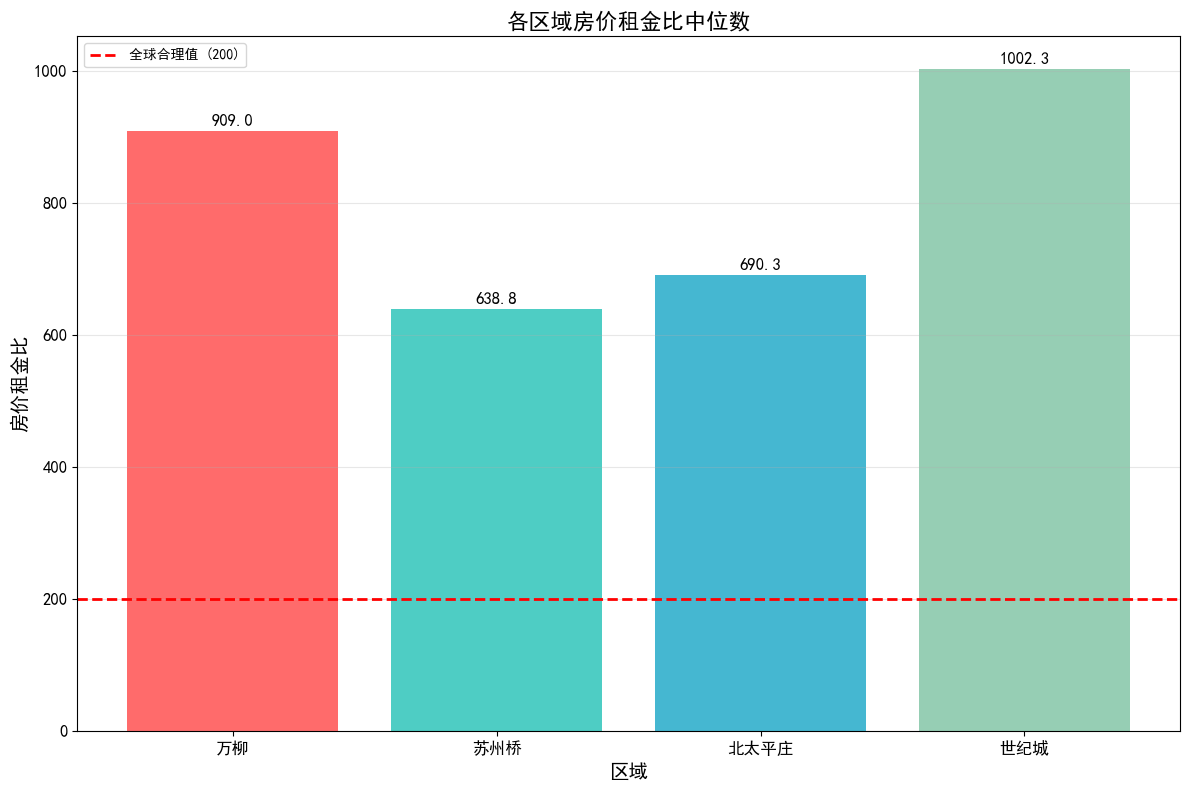


图表已保存为 '各区域房价租金比.png'

清洗后的数据已保存为 '清洗后二手房数据.xlsx' 和 '清洗后租房数据.xlsx'


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class HousingDataAnalyzer:
    def __init__(self):
        # 读取数据
        self.second_hand_df = pd.read_excel("所有区域二手房数据.xlsx")
        self.rental_df = pd.read_excel("所有区域租房数据.xlsx")
        
    def clean_data(self):
        """数据清洗：处理重复值和异常值"""
        print("开始数据清洗...")
        
        # 处理二手房数据
        print(f"二手房原始数据量: {len(self.second_hand_df)}")
        self.second_hand_df = self.second_hand_df.drop_duplicates()
        print(f"去重后二手房数据量: {len(self.second_hand_df)}")
        
        # 处理租房数据
        print(f"租房原始数据量: {len(self.rental_df)}")
        self.rental_df = self.rental_df.drop_duplicates()
        print(f"去重后租房数据量: {len(self.rental_df)}")
        
        # 处理异常值 - 使用IQR方法
        self.second_hand_df = self.remove_outliers_iqr(self.second_hand_df, '单价(元/㎡)')
        self.second_hand_df = self.remove_outliers_iqr(self.second_hand_df, '面积(㎡)')
        
        self.rental_df = self.remove_outliers_iqr(self.rental_df, '租金单价(元/㎡/月)')
        self.rental_df = self.remove_outliers_iqr(self.rental_df, '面积(㎡)')
        
        print(f"去除异常值后二手房数据量: {len(self.second_hand_df)}")
        print(f"去除异常值后租房数据量: {len(self.rental_df)}")
        
    def remove_outliers_iqr(self, df, column):
        """使用IQR方法去除异常值"""
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 保留在正常范围内的数据
        df_clean = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        outliers_count = len(df) - len(df_clean)
        
        if outliers_count > 0:
            print(f"在 {column} 中移除了 {outliers_count} 个异常值")
            
        return df_clean
    
    def data_description(self):
        """数据描述和异常值分析"""
        print("\n" + "="*60)
        print("数据描述和异常值分析")
        print("="*60)
        
        # 二手房数据描述
        print("\n=== 二手房数据描述 ===")
        for region in self.second_hand_df['区域'].unique():
            region_data = self.second_hand_df[self.second_hand_df['区域'] == region]
            print(f"\n--- {region} ---")
            print(f"记录数: {len(region_data)}")
            print(f"单价统计:")
            print(f"  平均值: {region_data['单价(元/㎡)'].mean():.2f} 元/㎡")
            print(f"  中位数: {region_data['单价(元/㎡)'].median():.2f} 元/㎡")
            print(f"  标准差: {region_data['单价(元/㎡)'].std():.2f} 元/㎡")
            print(f"  最小值: {region_data['单价(元/㎡)'].min():.2f} 元/㎡")
            print(f"  最大值: {region_data['单价(元/㎡)'].max():.2f} 元/㎡")
            
            # 检测异常值
            Q1 = region_data['单价(元/㎡)'].quantile(0.25)
            Q3 = region_data['单价(元/㎡)'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = region_data[(region_data['单价(元/㎡)'] < lower_bound) | 
                                 (region_data['单价(元/㎡)'] > upper_bound)]
            print(f"  单价异常值数量: {len(outliers)}")
        
        # 租房数据描述
        print("\n=== 租房数据描述 ===")
        for region in self.rental_df['区域'].unique():
            region_data = self.rental_df[self.rental_df['区域'] == region]
            print(f"\n--- {region} ---")
            print(f"记录数: {len(region_data)}")
            print(f"租金单价统计:")
            print(f"  平均值: {region_data['租金单价(元/㎡/月)'].mean():.2f} 元/㎡/月")
            print(f"  中位数: {region_data['租金单价(元/㎡/月)'].median():.2f} 元/㎡/月")
            print(f"  标准差: {region_data['租金单价(元/㎡/月)'].std():.2f} 元/㎡/月")
            print(f"  最小值: {region_data['租金单价(元/㎡/月)'].min():.2f} 元/㎡/月")
            print(f"  最大值: {region_data['租金单价(元/㎡/月)'].max():.2f} 元/㎡/月")
            
            # 检测异常值
            Q1 = region_data['租金单价(元/㎡/月)'].quantile(0.25)
            Q3 = region_data['租金单价(元/㎡/月)'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = region_data[(region_data['租金单价(元/㎡/月)'] < lower_bound) | 
                                 (region_data['租金单价(元/㎡/月)'] > upper_bound)]
            print(f"  租金单价异常值数量: {len(outliers)}")
    
    def calculate_price_rent_ratio(self):
        """计算房价租金比"""
        print("\n" + "="*60)
        print("房价租金比计算")
        print("="*60)
        
        ratios = {}
        
        for region in self.second_hand_df['区域'].unique():
            # 获取该区域的二手房和租房数据
            region_second_hand = self.second_hand_df[self.second_hand_df['区域'] == region]
            region_rental = self.rental_df[self.rental_df['区域'] == region]
            
            if len(region_second_hand) == 0 or len(region_rental) == 0:
                print(f"{region}: 数据不足，无法计算")
                continue
            
            # 计算中位数价格和租金
            median_price_per_sqm = region_second_hand['单价(元/㎡)'].median()
            median_rent_per_sqm = region_rental['租金单价(元/㎡/月)'].median()
            
            # 计算房价租金比 (单价/月租金)
            if median_rent_per_sqm > 0:
                price_rent_ratio = (median_price_per_sqm / median_rent_per_sqm) 
                ratios[region] = price_rent_ratio
                print(f"{region}: {price_rent_ratio:.2f} (单价: {median_price_per_sqm:.2f}元/㎡, 租金: {median_rent_per_sqm:.2f}元/㎡/月)")
            else:
                print(f"{region}: 租金数据异常")
        
        return ratios
    
    def plot_price_rent_ratio(self, ratios):
        """绘制房价租金比条形图"""
        if not ratios:
            print("没有可用的房价租金比数据")
            return
        
        regions = list(ratios.keys())
        values = list(ratios.values())
        
        plt.figure(figsize=(12, 8))
        bars = plt.bar(regions, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
        
        # 添加全球合理值参考线
        plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值 (200)')
        
        # 在柱子上添加数值标签
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{value:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        plt.xlabel('区域', fontsize=14, fontweight='bold')
        plt.ylabel('房价租金比', fontsize=14, fontweight='bold')
        plt.title('各区域房价租金比中位数', fontsize=16, fontweight='bold')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图片
        plt.savefig('各区域房价租金比.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n图表已保存为 '各区域房价租金比.png'")
    
    def save_cleaned_data(self):
        """保存清洗后的数据"""
        self.second_hand_df.to_excel("清洗后二手房数据.xlsx", index=False)
        self.rental_df.to_excel("清洗后租房数据.xlsx", index=False)
        print("\n清洗后的数据已保存为 '清洗后二手房数据.xlsx' 和 '清洗后租房数据.xlsx'")

# 主程序
def main():
    analyzer = HousingDataAnalyzer()
    
    try:
        # 1. 数据清洗
        analyzer.clean_data()
        
        # 2. 数据描述和异常值分析
        analyzer.data_description()
        
        # 3. 计算房价租金比
        ratios = analyzer.calculate_price_rent_ratio()
        
        # 4. 绘制房价租金比图表
        analyzer.plot_price_rent_ratio(ratios)
        
        # 5. 保存清洗后的数据
        analyzer.save_cleaned_data()
        
    except Exception as e:
        print(f"程序执行出错: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [3]:
!pip install seaborn

scikit-learn 已成功导入
数据读取成功
确保数据类型正确...
二手房数据剩余行数: 744
租房数据剩余行数: 520
准备建模数据...
二手房数据形状: (744, 5)
租房数据形状: (520, 5)
二手房特征数据类型:
面积(㎡)            float64
location_万柳      float64
location_世纪城     float64
location_北太平庄    float64
location_苏州桥     float64
dtype: object
二手房目标变量数据类型:
float64

构建二手房单价模型...
二手房单价模型系数:
截距 (β0): 88310.86
面积(㎡) 系数: 121.3025
location_万柳 系数: 26827.3233
location_世纪城 系数: 4915.2618
location_北太平庄 系数: -14317.2966
location_苏州桥 系数: -17425.2884
模型性能 - R²: 0.5214, RMSE: 19753.69

构建租房单价模型...
租房单价模型系数:
截距 (β0): 138.71
面积(㎡) 系数: -0.0506
location_万柳 系数: 18.9144
location_世纪城 系数: -15.3354
location_北太平庄 系数: 1.7264
location_苏州桥 系数: -5.3054
模型性能 - R²: 0.1260, RMSE: 28.71

开始预测房价租金比...
预测完成!
预测数据样本:
   区域   面积(㎡)      预测单价(元/㎡)  预测租金单价(元/㎡/月)      预测房价租金比
0  万柳  151.00  133454.861020     149.983635   889.796153
1  万柳  286.01  149831.914801     143.150156  1046.676574
2  万柳  305.08  152145.153936     142.184935  1070.051152
3  万柳  150.21  133359.032026     150.023620   888.920238
4  万柳  

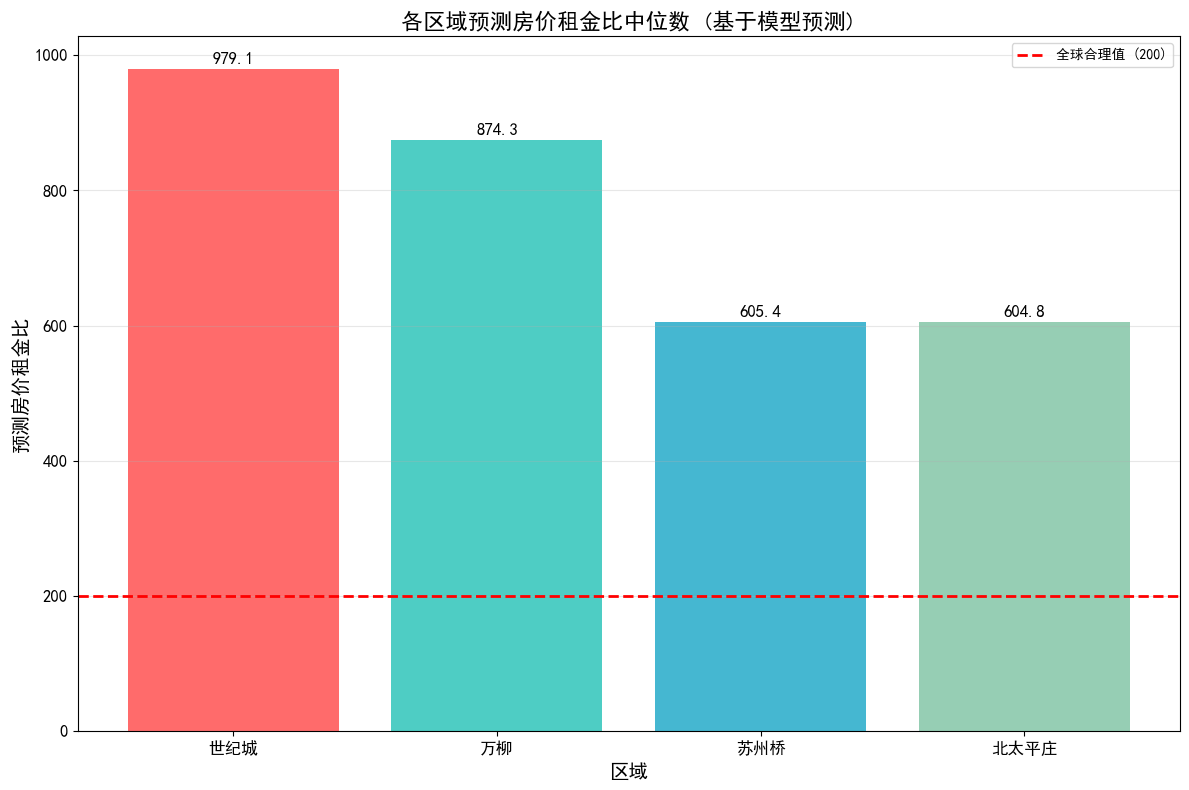


图表已保存为 '各区域预测房价租金比.png'

预测结果已保存为 '房价租金比预测结果.xlsx'


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 检查并安装缺失的包
try:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score, mean_squared_error
    print("scikit-learn 已成功导入")
except ImportError:
    print("正在安装 scikit-learn...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score, mean_squared_error
    print("scikit-learn 安装成功并已导入")

class HousingPriceRentModel:
    def __init__(self):
        # 读取清洗后的数据
        try:
            self.second_hand_df = pd.read_excel("清洗后二手房数据.xlsx")
            self.rental_df = pd.read_excel("清洗后租房数据.xlsx")
            print("数据读取成功")
            
            # 确保数据类型正确
            self._ensure_data_types()
            
        except FileNotFoundError:
            print("找不到数据文件，请确保 '清洗后二手房数据.xlsx' 和 '清洗后租房数据.xlsx' 在当前目录")
            # 创建空数据框以避免后续错误
            self.second_hand_df = pd.DataFrame()
            self.rental_df = pd.DataFrame()
        
        # 存储模型结果
        self.model1 = None  # 二手房单价模型
        self.model2 = None  # 租房单价模型
        self.predictions = None
    
    def _ensure_data_types(self):
        """确保所有数值列都是正确的数据类型"""
        print("确保数据类型正确...")
        
        # 二手房数据
        if not self.second_hand_df.empty:
            self.second_hand_df['面积(㎡)'] = pd.to_numeric(self.second_hand_df['面积(㎡)'], errors='coerce')
            self.second_hand_df['价格(万)'] = pd.to_numeric(self.second_hand_df['价格(万)'], errors='coerce')
            self.second_hand_df['单价(元/㎡)'] = pd.to_numeric(self.second_hand_df['单价(元/㎡)'], errors='coerce')
            
            # 移除任何可能包含NaN的行
            self.second_hand_df = self.second_hand_df.dropna()
            
        # 租房数据
        if not self.rental_df.empty:
            self.rental_df['面积(㎡)'] = pd.to_numeric(self.rental_df['面积(㎡)'], errors='coerce')
            self.rental_df['租金(元/月)'] = pd.to_numeric(self.rental_df['租金(元/月)'], errors='coerce')
            self.rental_df['租金单价(元/㎡/月)'] = pd.to_numeric(self.rental_df['租金单价(元/㎡/月)'], errors='coerce')
            
            # 移除任何可能包含NaN的行
            self.rental_df = self.rental_df.dropna()
            
        print(f"二手房数据剩余行数: {len(self.second_hand_df)}")
        print(f"租房数据剩余行数: {len(self.rental_df)}")
        
    def prepare_data(self):
        """准备建模数据，创建区域哑变量"""
        if self.second_hand_df.empty or self.rental_df.empty:
            print("数据为空，无法准备建模数据")
            return False
            
        print("准备建模数据...")
        
        # 为二手房数据创建哑变量
        second_hand_dummies = pd.get_dummies(self.second_hand_df['区域'], prefix='location')
        self.X1 = pd.concat([self.second_hand_df['面积(㎡)'], second_hand_dummies], axis=1)
        self.y1 = self.second_hand_df['单价(元/㎡)']
        
        # 确保所有数据都是数值类型
        self.X1 = self.X1.astype(float)
        self.y1 = self.y1.astype(float)
        
        # 为租房数据创建哑变量
        rental_dummies = pd.get_dummies(self.rental_df['区域'], prefix='location')
        self.X2 = pd.concat([self.rental_df['面积(㎡)'], rental_dummies], axis=1)
        self.y2 = self.rental_df['租金单价(元/㎡/月)']
        
        # 确保所有数据都是数值类型
        self.X2 = self.X2.astype(float)
        self.y2 = self.y2.astype(float)
        
        print(f"二手房数据形状: {self.X1.shape}")
        print(f"租房数据形状: {self.X2.shape}")
        
        # 打印数据类型以进行调试
        print("二手房特征数据类型:")
        print(self.X1.dtypes)
        print("二手房目标变量数据类型:")
        print(self.y1.dtype)
        
        return True
        
    def build_model1(self):
        """构建二手房单价模型: price/m2 = β0 + β1*area + β2*location + ε"""
        if self.X1.empty:
            print("二手房数据为空，无法构建模型")
            return None
            
        print("\n构建二手房单价模型...")
        
        # 使用scikit-learn构建模型
        self.model1 = LinearRegression()
        
        # 将数据转换为numpy数组，确保数据类型一致
        X1_array = np.asarray(self.X1, dtype=float)
        y1_array = np.asarray(self.y1, dtype=float)
        
        self.model1.fit(X1_array, y1_array)
        
        # 计算模型性能指标
        y1_pred = self.model1.predict(X1_array)
        r2 = r2_score(y1_array, y1_pred)
        rmse = np.sqrt(mean_squared_error(y1_array, y1_pred))
        
        print("二手房单价模型系数:")
        print(f"截距 (β0): {self.model1.intercept_:.2f}")
        for i, col in enumerate(self.X1.columns):
            print(f"{col} 系数: {self.model1.coef_[i]:.4f}")
        
        print(f"模型性能 - R²: {r2:.4f}, RMSE: {rmse:.2f}")
        
        return self.model1
    
    def build_model2(self):
        """构建租房单价模型: rent/m2 = β0 + β1*area + β2*location + ε"""
        if self.X2.empty:
            print("租房数据为空，无法构建模型")
            return None
            
        print("\n构建租房单价模型...")
        
        # 使用scikit-learn构建模型
        self.model2 = LinearRegression()
        
        # 将数据转换为numpy数组，确保数据类型一致
        X2_array = np.asarray(self.X2, dtype=float)
        y2_array = np.asarray(self.y2, dtype=float)
        
        self.model2.fit(X2_array, y2_array)
        
        # 计算模型性能指标
        y2_pred = self.model2.predict(X2_array)
        r2 = r2_score(y2_array, y2_pred)
        rmse = np.sqrt(mean_squared_error(y2_array, y2_pred))
        
        print("租房单价模型系数:")
        print(f"截距 (β0): {self.model2.intercept_:.2f}")
        for i, col in enumerate(self.X2.columns):
            print(f"{col} 系数: {self.model2.coef_[i]:.4f}")
        
        print(f"模型性能 - R²: {r2:.4f}, RMSE: {rmse:.2f}")
        
        return self.model2
    
    def predict_price_rent_ratio(self):
        """使用两个模型预测所有数据的房价和租金，并计算房价租金比"""
        if self.model1 is None or self.model2 is None:
            print("模型未训练，无法进行预测")
            return None
            
        print("\n开始预测房价租金比...")
        
        # 合并所有数据用于预测
        all_data = pd.concat([self.second_hand_df, self.rental_df], ignore_index=True)
        
        # 为所有数据创建哑变量
        all_dummies = pd.get_dummies(all_data['区域'], prefix='location')
        X_all = pd.concat([all_data['面积(㎡)'], all_dummies], axis=1)
        
        # 确保哑变量列一致（填充缺失的列）
        for col in self.X1.columns:
            if col not in X_all.columns and col != '面积(㎡)':
                X_all[col] = 0
        
        # 重新排列列顺序以匹配模型
        X_all = X_all[self.X1.columns]
        
        # 确保数据类型正确
        X_all = X_all.astype(float)
        X_all_array = np.asarray(X_all, dtype=float)
        
        # 使用模型1预测二手房单价
        predicted_price_per_m2 = self.model1.predict(X_all_array)
        
        # 使用模型2预测租房单价
        predicted_rent_per_m2 = self.model2.predict(X_all_array)
        
        # 计算房价租金比
        price_rent_ratio = (predicted_price_per_m2 / predicted_rent_per_m2)
        
        # 创建包含预测结果的数据框
        self.predictions = pd.DataFrame({
            '区域': all_data['区域'],
            '面积(㎡)': all_data['面积(㎡)'],
            '预测单价(元/㎡)': predicted_price_per_m2,
            '预测租金单价(元/㎡/月)': predicted_rent_per_m2,
            '预测房价租金比': price_rent_ratio
        })
        
        print("预测完成!")
        print(f"预测数据样本:")
        print(self.predictions.head())
        
        return self.predictions
    
    def calculate_median_ratio_by_block(self):
        """按区域计算中位数房价租金比"""
        if self.predictions is None:
            print("没有预测数据，无法计算中位数")
            return None
            
        median_ratios = self.predictions.groupby('区域')['预测房价租金比'].median().sort_values(ascending=False)
        
        print("\n各区域预测房价租金比中位数:")
        for region, ratio in median_ratios.items():
            print(f"{region}: {ratio:.2f}")
        
        return median_ratios
    
    def plot_median_price_rent_ratio(self, median_ratios):
        """绘制各区域中位数房价租金比条形图"""
        if median_ratios is None:
            print("没有可用的房价租金比数据")
            return
        
        regions = median_ratios.index.tolist()
        values = median_ratios.values.tolist()
        
        plt.figure(figsize=(12, 8))
        bars = plt.bar(regions, values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
        
        # 添加全球合理值参考线
        plt.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值 (200)')
        
        # 在柱子上添加数值标签
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                    f'{value:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        plt.xlabel('区域', fontsize=14, fontweight='bold')
        plt.ylabel('预测房价租金比', fontsize=14, fontweight='bold')
        plt.title('各区域预测房价租金比中位数 (基于模型预测)', fontsize=16, fontweight='bold')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图片
        plt.savefig('各区域预测房价租金比.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\n图表已保存为 '各区域预测房价租金比.png'")
    
    def save_predictions(self):
        """保存预测结果"""
        if self.predictions is None:
            print("没有预测数据可保存")
            return
            
        self.predictions.to_excel("房价租金比预测结果.xlsx", index=False)
        print("\n预测结果已保存为 '房价租金比预测结果.xlsx'")

# 主程序
def main():
    model = HousingPriceRentModel()
    
    try:
        # 1. 准备数据
        if not model.prepare_data():
            return
            
        # 2. 构建模型1（二手房单价模型）
        model.build_model1()
        
        # 3. 构建模型2（租房单价模型）
        model.build_model2()
        
        # 4. 预测房价租金比
        model.predict_price_rent_ratio()
        
        # 5. 计算各区域中位数房价租金比
        median_ratios = model.calculate_median_ratio_by_block()
        
        # 6. 绘制条形图
        if median_ratios is not None:
            model.plot_median_price_rent_ratio(median_ratios)
        
        # 7. 保存预测结果
        model.save_predictions()
        
    except Exception as e:
        print(f"程序执行出错: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [2]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------- ----------------------------- 2.6/9.6 MB 11.6 MB/s eta 0:00:01
   ------------------ --------------------- 4.5/9.6 MB 10.7 MB/s eta 0:00:01
   ------------------------------- -------- 7.6/9.6 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 11.3 MB/s eta 0:00:00


In [5]:
!pip install scikit-learn

   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   --------------------------------- ------ 7.3/8.7 MB 75.3 MB/s eta 0:00:01
   ------------------------------------- -- 8.1/8.7 MB 50.4 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 19.3 MB/s eta 0:00:00


数据读取成功
确保数据类型正确...
二手房数据剩余行数: 744
租房数据剩余行数: 520
准备建模数据...
二手房数据形状: (744, 5)
租房数据形状: (520, 5)

构建简单线性模型

构建二手房单价简单模型 (Model 1)...
二手房简单模型 R²: 0.5214

构建租房单价简单模型 (Model 2)...
租房简单模型 R²: 0.1260

构建增强模型（带正则化）

构建二手房单价增强模型 (Model 1+)...
二手房增强模型 R²: 0.5382

构建租房单价增强模型 (Model 2+)...
租房增强模型 R²: 0.2315

模型性能比较

二手房模型比较:
简单模型 R²: 0.5214
增强模型 R²: 0.5382
R²提升: 0.0167
增强模型表现更好，因为引入了非线性关系和交互作用，能更好地捕捉数据中的复杂模式

租房模型比较:
简单模型 R²: 0.1260
增强模型 R²: 0.2315
R²提升: 0.1055
增强模型表现更好，因为引入了非线性关系和交互作用，能更好地捕捉数据中的复杂模式

使用所有模型进行预测
预测完成!

绘制房价租金比比较图


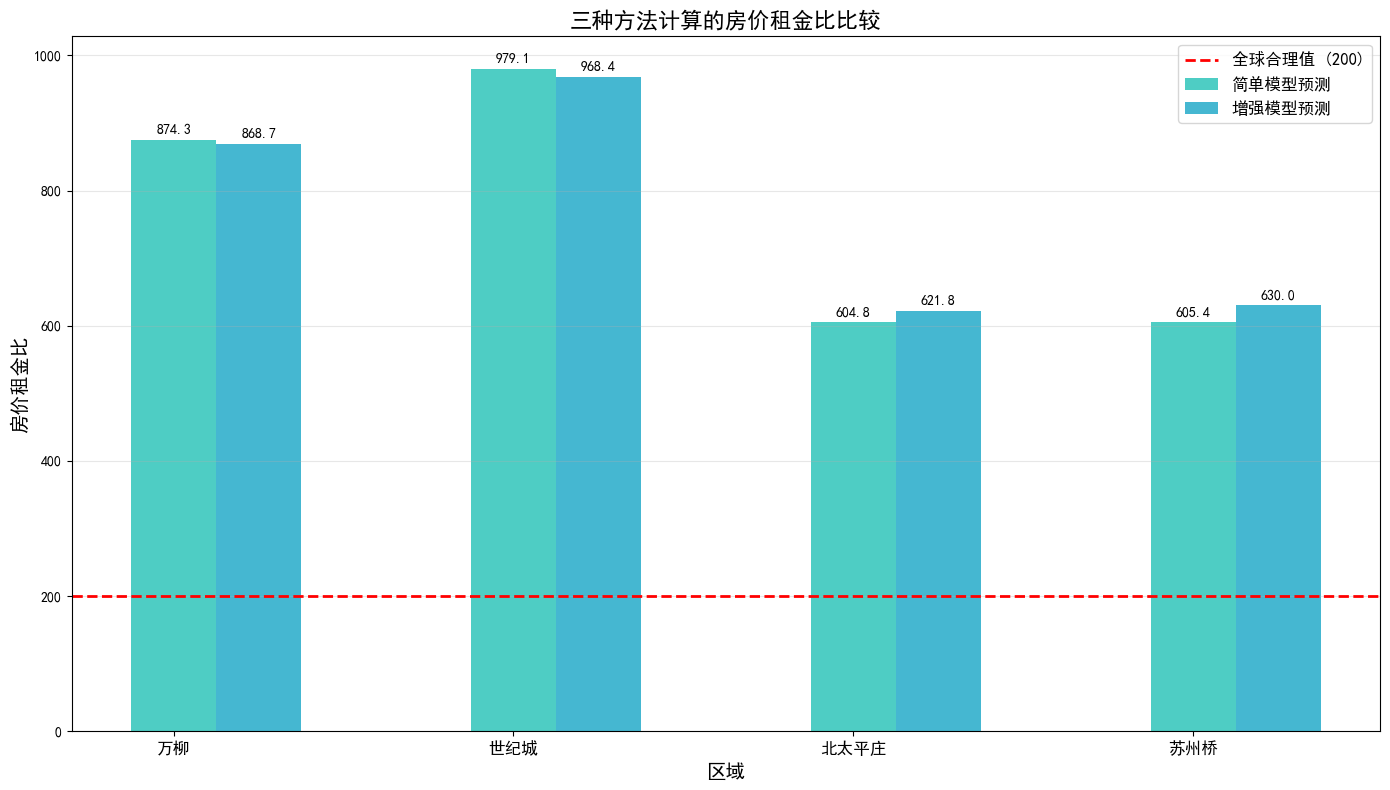

图表已保存为 '三种方法房价租金比比较.png'

基于样本量的可信度分析
各区域样本量:
世纪城: 二手房 267 条, 租房 116 条
万柳: 二手房 208 条, 租房 67 条
苏州桥: 二手房 156 条, 租房 191 条
北太平庄: 二手房 113 条, 租房 146 条

可信度分析:
1. 原始数据中位数方法: 直接使用观测值，但可能受异常值影响
2. 简单模型预测: 考虑了面积和区域的基本关系，适合样本量适中的情况
3. 增强模型预测: 捕捉更复杂的关系，但需要足够样本量支持，否则可能过拟合
区域 世纪城 样本量充足 (383)，模型结果较为可靠
区域 万柳 样本量充足 (275)，模型结果较为可靠
区域 苏州桥 样本量充足 (347)，模型结果较为可靠
区域 北太平庄 样本量充足 (259)，模型结果较为可靠

总体建议:
- 样本量充足时: 增强模型通常能提供更准确的预测
- 样本量有限时: 简单模型或原始数据中位数可能更可靠
- 异常值较多时: 模型预测通常比原始数据中位数更稳健
简单模型预测结果已保存为 '简单模型预测结果.xlsx'
增强模型预测结果已保存为 '增强模型预测结果.xlsx'


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import os

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

class EnhancedHousingModel:
    def __init__(self):
        # 读取清洗后的数据
        try:
            self.second_hand_df = pd.read_excel("清洗后二手房数据.xlsx")
            self.rental_df = pd.read_excel("清洗后租房数据.xlsx")
            print("数据读取成功")
            
            # 确保数据类型正确
            self._ensure_data_types()
            
        except FileNotFoundError:
            print("找不到数据文件，请确保 '清洗后二手房数据.xlsx' 和 '清洗后租房数据.xlsx' 在当前目录")
            self.second_hand_df = pd.DataFrame()
            self.rental_df = pd.DataFrame()
        
        # 存储模型结果
        self.model1 = None  # 简单二手房模型
        self.model2 = None  # 简单租房模型
        self.model1_plus = None  # 增强二手房模型
        self.model2_plus = None  # 增强租房模型
        self.predictions_simple = None  # 简单模型预测
        self.predictions_enhanced = None  # 增强模型预测
    
    def _ensure_data_types(self):
        """确保所有数值列都是正确的数据类型"""
        print("确保数据类型正确...")
        
        # 二手房数据
        if not self.second_hand_df.empty:
            self.second_hand_df['面积(㎡)'] = pd.to_numeric(self.second_hand_df['面积(㎡)'], errors='coerce')
            self.second_hand_df['价格(万)'] = pd.to_numeric(self.second_hand_df['价格(万)'], errors='coerce')
            self.second_hand_df['单价(元/㎡)'] = pd.to_numeric(self.second_hand_df['单价(元/㎡)'], errors='coerce')
            self.second_hand_df = self.second_hand_df.dropna()
            
        # 租房数据
        if not self.rental_df.empty:
            self.rental_df['面积(㎡)'] = pd.to_numeric(self.rental_df['面积(㎡)'], errors='coerce')
            self.rental_df['租金(元/月)'] = pd.to_numeric(self.rental_df['租金(元/月)'], errors='coerce')
            self.rental_df['租金单价(元/㎡/月)'] = pd.to_numeric(self.rental_df['租金单价(元/㎡/月)'], errors='coerce')
            self.rental_df = self.rental_df.dropna()
            
        print(f"二手房数据剩余行数: {len(self.second_hand_df)}")
        print(f"租房数据剩余行数: {len(self.rental_df)}")
        
    def prepare_data(self):
        """准备建模数据"""
        if self.second_hand_df.empty or self.rental_df.empty:
            print("数据为空，无法准备建模数据")
            return False
            
        print("准备建模数据...")
        
        # 为二手房数据创建哑变量
        second_hand_dummies = pd.get_dummies(self.second_hand_df['区域'], prefix='location')
        self.X1 = pd.concat([self.second_hand_df['面积(㎡)'], second_hand_dummies], axis=1)
        self.y1 = self.second_hand_df['单价(元/㎡)']
        
        # 为租房数据创建哑变量
        rental_dummies = pd.get_dummies(self.rental_df['区域'], prefix='location')
        self.X2 = pd.concat([self.rental_df['面积(㎡)'], rental_dummies], axis=1)
        self.y2 = self.rental_df['租金单价(元/㎡/月)']
        
        # 确保所有数据都是数值类型
        self.X1 = self.X1.astype(float)
        self.y1 = self.y1.astype(float)
        self.X2 = self.X2.astype(float)
        self.y2 = self.y2.astype(float)
        
        print(f"二手房数据形状: {self.X1.shape}")
        print(f"租房数据形状: {self.X2.shape}")
        
        return True
    
    def create_enhanced_features(self, X, area_col='面积(㎡)'):
        """创建非线性特征和交互特征"""
        X_enhanced = X.copy()
        
        # 非线性特征
        X_enhanced[f'{area_col}_squared'] = X_enhanced[area_col] ** 2
        X_enhanced[f'{area_col}_sqrt'] = np.sqrt(X_enhanced[area_col])
        X_enhanced[f'{area_col}_log'] = np.log(X_enhanced[area_col] + 1)  # +1 避免对数零
        
        # 交互特征 - 面积与区域的交互
        location_cols = [col for col in X_enhanced.columns if col.startswith('location_')]
        for loc_col in location_cols:
            X_enhanced[f'{area_col}_{loc_col}_interaction'] = X_enhanced[area_col] * X_enhanced[loc_col]
        
        # 标准化数值特征
        numeric_cols = [area_col, f'{area_col}_squared', f'{area_col}_sqrt', f'{area_col}_log']
        for col in numeric_cols:
            if col in X_enhanced.columns:
                X_enhanced[col] = (X_enhanced[col] - X_enhanced[col].mean()) / X_enhanced[col].std()
        
        return X_enhanced
    
    def build_simple_models(self):
        """构建简单线性模型 (Model 1 和 Model 2)"""
        print("\n" + "="*50)
        print("构建简单线性模型")
        print("="*50)
        
        # 模型1: 二手房单价模型
        if not self.X1.empty:
            print("\n构建二手房单价简单模型 (Model 1)...")
            self.model1 = LinearRegression()
            X1_array = np.asarray(self.X1, dtype=float)
            y1_array = np.asarray(self.y1, dtype=float)
            self.model1.fit(X1_array, y1_array)
            
            y1_pred = self.model1.predict(X1_array)
            r2_1 = r2_score(y1_array, y1_pred)
            print(f"二手房简单模型 R²: {r2_1:.4f}")
        
        # 模型2: 租房单价模型
        if not self.X2.empty:
            print("\n构建租房单价简单模型 (Model 2)...")
            self.model2 = LinearRegression()
            X2_array = np.asarray(self.X2, dtype=float)
            y2_array = np.asarray(self.y2, dtype=float)
            self.model2.fit(X2_array, y2_array)
            
            y2_pred = self.model2.predict(X2_array)
            r2_2 = r2_score(y2_array, y2_pred)
            print(f"租房简单模型 R²: {r2_2:.4f}")
    
    def build_enhanced_models(self):
        """构建增强模型，添加正则化避免过拟合"""
        print("\n" + "="*50)
        print("构建增强模型（带正则化）")
        print("="*50)
        
        # 模型1+: 二手房单价增强模型
        if not self.X1.empty:
            print("\n构建二手房单价增强模型 (Model 1+)...")
            X1_enhanced = self.create_enhanced_features(self.X1)
        
            # 使用岭回归（L2正则化）避免过拟合
            from sklearn.linear_model import Ridge
            self.model1_plus = Ridge(alpha=1.0)  # 正则化强度
        
            X1_enhanced_array = np.asarray(X1_enhanced, dtype=float)
            y1_array = np.asarray(self.y1, dtype=float)
            self.model1_plus.fit(X1_enhanced_array, y1_array)
        
            y1_pred_plus = self.model1_plus.predict(X1_enhanced_array)
            r2_1_plus = r2_score(y1_array, y1_pred_plus)
            print(f"二手房增强模型 R²: {r2_1_plus:.4f}")
            
            # 存储增强特征
            self.X1_enhanced = X1_enhanced
    
        # 模型2+: 租房单价增强模型
        if not self.X2.empty:
            print("\n构建租房单价增强模型 (Model 2+)...")
            X2_enhanced = self.create_enhanced_features(self.X2)
        
            # 使用岭回归
            self.model2_plus = Ridge(alpha=1.0)
        
            X2_enhanced_array = np.asarray(X2_enhanced, dtype=float)
            y2_array = np.asarray(self.y2, dtype=float)
            self.model2_plus.fit(X2_enhanced_array, y2_array)
        
            y2_pred_plus = self.model2_plus.predict(X2_enhanced_array)
            r2_2_plus = r2_score(y2_array, y2_pred_plus)
            print(f"租房增强模型 R²: {r2_2_plus:.4f}")
            
            # 存储增强特征
            self.X2_enhanced = X2_enhanced

    def create_enhanced_features(self, X, area_col='面积(㎡)'):
        """创建非线性特征和交互特征，添加异常值处理"""
        X_enhanced = X.copy()
    
        # 非线性特征
        X_enhanced[f'{area_col}_squared'] = X_enhanced[area_col] ** 2
        X_enhanced[f'{area_col}_sqrt'] = np.sqrt(np.abs(X_enhanced[area_col]))  # 避免负数的平方根
    
        # 对数值特征进行缩尾处理，减少异常值影响
        for col in [area_col, f'{area_col}_squared', f'{area_col}_sqrt']:
            if col in X_enhanced.columns:
                # 缩尾处理：将极端值替换为分位数
                q_low = X_enhanced[col].quantile(0.05)
                q_high = X_enhanced[col].quantile(0.95)
                X_enhanced[col] = np.clip(X_enhanced[col], q_low, q_high)
        
        # 交互特征 - 面积与区域的交互
        location_cols = [col for col in X_enhanced.columns if col.startswith('location_')]
        for loc_col in location_cols:
            X_enhanced[f'{area_col}_{loc_col}_interaction'] = X_enhanced[area_col] * X_enhanced[loc_col]
    
        return X_enhanced
    
    def compare_models(self):
        """比较简单模型和增强模型的性能"""
        print("\n" + "="*50)
        print("模型性能比较")
        print("="*50)
        
        # 计算简单模型R²
        if self.model1 is not None:
            X1_array = np.asarray(self.X1, dtype=float)
            y1_array = np.asarray(self.y1, dtype=float)
            y1_pred = self.model1.predict(X1_array)
            r2_1 = r2_score(y1_array, y1_pred)
        
        if self.model2 is not None:
            X2_array = np.asarray(self.X2, dtype=float)
            y2_array = np.asarray(self.y2, dtype=float)
            y2_pred = self.model2.predict(X2_array)
            r2_2 = r2_score(y2_array, y2_pred)
        
        # 计算增强模型R²
        if self.model1_plus is not None:
            X1_enhanced_array = np.asarray(self.X1_enhanced, dtype=float)
            y1_pred_plus = self.model1_plus.predict(X1_enhanced_array)
            r2_1_plus = r2_score(y1_array, y1_pred_plus)
            
            print(f"\n二手房模型比较:")
            print(f"简单模型 R²: {r2_1:.4f}")
            print(f"增强模型 R²: {r2_1_plus:.4f}")
            print(f"R²提升: {r2_1_plus - r2_1:.4f}")
            
            if r2_1_plus > r2_1:
                print("增强模型表现更好，因为引入了非线性关系和交互作用，能更好地捕捉数据中的复杂模式")
            else:
                print("简单模型表现更好，可能是因为增强模型过拟合或数据本身关系简单")
        
        if self.model2_plus is not None:
            X2_enhanced_array = np.asarray(self.X2_enhanced, dtype=float)
            y2_pred_plus = self.model2_plus.predict(X2_enhanced_array)
            r2_2_plus = r2_score(y2_array, y2_pred_plus)
            
            print(f"\n租房模型比较:")
            print(f"简单模型 R²: {r2_2:.4f}")
            print(f"增强模型 R²: {r2_2_plus:.4f}")
            print(f"R²提升: {r2_2_plus - r2_2:.4f}")
            
            if r2_2_plus > r2_2:
                print("增强模型表现更好，因为引入了非线性关系和交互作用，能更好地捕捉数据中的复杂模式")
            else:
                print("简单模型表现更好，可能是因为增强模型过拟合或数据本身关系简单")
    
    def predict_with_all_models(self):
        """使用所有模型进行预测并计算房价租金比"""
        print("\n" + "="*50)
        print("使用所有模型进行预测")
        print("="*50)
        
        # 合并所有数据用于预测
        all_data = pd.concat([self.second_hand_df, self.rental_df], ignore_index=True)
        
        # 为所有数据创建哑变量
        all_dummies = pd.get_dummies(all_data['区域'], prefix='location')
        X_all = pd.concat([all_data['面积(㎡)'], all_dummies], axis=1)
        
        # 确保哑变量列一致
        for col in self.X1.columns:
            if col not in X_all.columns and col != '面积(㎡)':
                X_all[col] = 0
        X_all = X_all[self.X1.columns]
        
        # 创建增强特征
        X_all_enhanced = self.create_enhanced_features(X_all)
        
        # 确保数据类型正确
        X_all = X_all.astype(float)
        X_all_array = np.asarray(X_all, dtype=float)
        X_all_enhanced_array = np.asarray(X_all_enhanced, dtype=float)
        
        # 使用简单模型预测
        if self.model1 is not None and self.model2 is not None:
            predicted_price_simple = self.model1.predict(X_all_array)
            predicted_rent_simple = self.model2.predict(X_all_array)
            price_rent_ratio_simple = (predicted_price_simple / predicted_rent_simple) 
            
            self.predictions_simple = pd.DataFrame({
                '区域': all_data['区域'],
                '面积(㎡)': all_data['面积(㎡)'],
                '预测单价(元/㎡)': predicted_price_simple,
                '预测租金单价(元/㎡/月)': predicted_rent_simple,
                '预测房价租金比': price_rent_ratio_simple,
                '模型类型': '简单模型'
            })
        
        # 使用增强模型预测
        if self.model1_plus is not None and self.model2_plus is not None:
            predicted_price_enhanced = self.model1_plus.predict(X_all_enhanced_array)
            predicted_rent_enhanced = self.model2_plus.predict(X_all_enhanced_array)
            price_rent_ratio_enhanced = (predicted_price_enhanced / predicted_rent_enhanced) 
            
            self.predictions_enhanced = pd.DataFrame({
                '区域': all_data['区域'],
                '面积(㎡)': all_data['面积(㎡)'],
                '预测单价(元/㎡)': predicted_price_enhanced,
                '预测租金单价(元/㎡/月)': predicted_rent_enhanced,
                '预测房价租金比': price_rent_ratio_enhanced,
                '模型类型': '增强模型'
            })
        
        print("预测完成!")
        
        return self.predictions_simple, self.predictions_enhanced
    
    def plot_comparison(self):
        """绘制三种方法的房价租金比比较图"""
        print("\n" + "="*50)
        print("绘制房价租金比比较图")
        print("="*50)
        
        # 计算原始数据的中位数房价租金比（方法1）
        if hasattr(self, 'original_ratios'):
            original_medians = self.original_ratios
        else:
            # 如果没有原始数据，使用简单模型预测结果计算
            if self.predictions_simple is not None:
                original_medians = self.predictions_simple.groupby('区域')['预测房价租金比'].median()
        
        # 计算简单模型预测的中位数（方法2）
        if self.predictions_simple is not None:
            simple_medians = self.predictions_simple.groupby('区域')['预测房价租金比'].median()
        
        # 计算增强模型预测的中位数（方法3）
        if self.predictions_enhanced is not None:
            enhanced_medians = self.predictions_enhanced.groupby('区域')['预测房价租金比'].median()
        
        # 准备绘图数据
        regions = simple_medians.index.tolist() if self.predictions_simple is not None else []
        
        # 创建比较图
        fig, ax = plt.subplots(figsize=(14, 8))
        
        x = np.arange(len(regions))
        width = 0.25
        
        # 绘制三种方法的柱状图
        if hasattr(self, 'original_ratios'):
            rects1 = ax.bar(x - width, [original_medians.get(region, 0) for region in regions], 
                           width, label='原始数据中位数', color='#FF6B6B')
        
        if self.predictions_simple is not None:
            rects2 = ax.bar(x, [simple_medians.get(region, 0) for region in regions], 
                           width, label='简单模型预测', color='#4ECDC4')
        
        if self.predictions_enhanced is not None:
            rects3 = ax.bar(x + width, [enhanced_medians.get(region, 0) for region in regions], 
                           width, label='增强模型预测', color='#45B7D1')
        
        # 添加全球合理值参考线
        ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='全球合理值 (200)')
        
        # 设置图表属性
        ax.set_xlabel('区域', fontsize=14, fontweight='bold')
        ax.set_ylabel('房价租金比', fontsize=14, fontweight='bold')
        ax.set_title('三种方法计算的房价租金比比较', fontsize=16, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(regions, fontsize=12)
        ax.legend(fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        # 添加数值标签
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.1f}',
                           xy=(rect.get_x() + rect.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        if hasattr(self, 'original_ratios'):
            autolabel(rects1)
        if self.predictions_simple is not None:
            autolabel(rects2)
        if self.predictions_enhanced is not None:
            autolabel(rects3)
        
        plt.tight_layout()
        plt.savefig('三种方法房价租金比比较.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("图表已保存为 '三种方法房价租金比比较.png'")
    
    def analyze_trustworthiness(self):
        """基于样本量分析哪种方法更可信"""
        print("\n" + "="*50)
        print("基于样本量的可信度分析")
        print("="*50)
        
        # 计算各区域样本量
        region_counts = {}
        if not self.second_hand_df.empty:
            second_hand_counts = self.second_hand_df['区域'].value_counts()
            for region, count in second_hand_counts.items():
                if region not in region_counts:
                    region_counts[region] = {'二手房': 0, '租房': 0}
                region_counts[region]['二手房'] = count
        
        if not self.rental_df.empty:
            rental_counts = self.rental_df['区域'].value_counts()
            for region, count in rental_counts.items():
                if region not in region_counts:
                    region_counts[region] = {'二手房': 0, '租房': 0}
                region_counts[region]['租房'] = count
        
        print("各区域样本量:")
        for region, counts in region_counts.items():
            print(f"{region}: 二手房 {counts.get('二手房', 0)} 条, 租房 {counts.get('租房', 0)} 条")
        
        # 分析可信度
        print("\n可信度分析:")
        print("1. 原始数据中位数方法: 直接使用观测值，但可能受异常值影响")
        print("2. 简单模型预测: 考虑了面积和区域的基本关系，适合样本量适中的情况")
        print("3. 增强模型预测: 捕捉更复杂的关系，但需要足够样本量支持，否则可能过拟合")
        
        # 基于样本量给出建议
        min_samples = 30  # 认为足够建模的最小样本量
        for region, counts in region_counts.items():
            total_samples = counts.get('二手房', 0) + counts.get('租房', 0)
            if total_samples < min_samples:
                print(f"区域 {region} 样本量较少 ({total_samples})，建议谨慎解释模型结果")
            else:
                print(f"区域 {region} 样本量充足 ({total_samples})，模型结果较为可靠")
        
        # 总体建议
        print("\n总体建议:")
        print("- 样本量充足时: 增强模型通常能提供更准确的预测")
        print("- 样本量有限时: 简单模型或原始数据中位数可能更可靠")
        print("- 异常值较多时: 模型预测通常比原始数据中位数更稳健")
    
    def save_results(self):
        """保存所有结果"""
        if self.predictions_simple is not None:
            self.predictions_simple.to_excel("简单模型预测结果.xlsx", index=False)
            print("简单模型预测结果已保存为 '简单模型预测结果.xlsx'")
        
        if self.predictions_enhanced is not None:
            self.predictions_enhanced.to_excel("增强模型预测结果.xlsx", index=False)
            print("增强模型预测结果已保存为 '增强模型预测结果.xlsx'")

# 主程序
def main():
    model = EnhancedHousingModel()
    
    try:
        # 1. 准备数据
        if not model.prepare_data():
            return
            
        # 2. 构建简单模型
        model.build_simple_models()
        
        # 3. 构建增强模型
        model.build_enhanced_models()
        
        # 4. 比较模型性能
        model.compare_models()
        
        # 5. 使用所有模型进行预测
        model.predict_with_all_models()
        
        # 6. 绘制比较图
        model.plot_comparison()
        
        # 7. 基于样本量分析可信度
        model.analyze_trustworthiness()
        
        # 8. 保存结果
        model.save_results()
        
    except Exception as e:
        print(f"程序执行出错: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()